In [1]:
#Importar bibliotecas

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
import igraph as ig

In [4]:
#Cargar la matriz de correlaciones para cada razón alpha

alphas=[350, 380, 400, 420, 450]
correlacionClausula={alpha:(np.load('D/correlacion_clausulas_100alpha-'+str(alpha)+'.npy')) for alpha in alphas}

alpha 	 correlacion media 	 cláusulas 	 cláusulas analizadas
3.5 	 0.0008680058436815069 	 175000 	 37
3.8 	 0.0005373863833102329 	 190000 	 304
4.0 	 0.0007239140468333722 	 200000 	 614
4.2 	 0.0009482818592105791 	 210000 	 948
4.5 	 0.001338838539546605 	 225000 	 1451


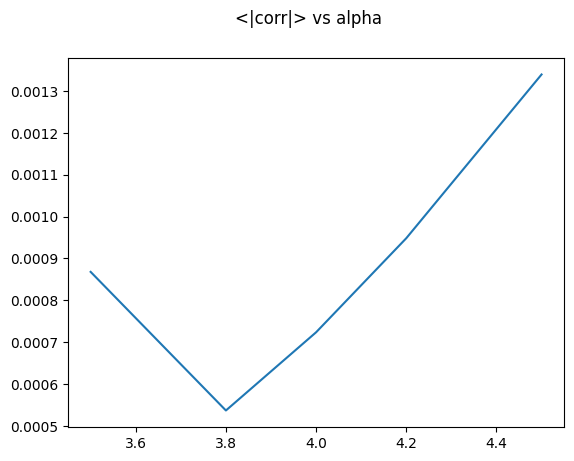

In [5]:
#Mínimo en la media del valor absoluto de la correlación cerca de la transición

print("alpha","\t","correlacion media","\t","cláusulas","\t","cláusulas analizadas")
for alpha in alphas:
    print(alpha/100,"\t",np.mean(np.abs(correlacionClausula[alpha])),"\t",alpha*500,"\t",np.shape(correlacionClausula[alpha])[0])

plt.suptitle("<|corr|> vs alpha")
plt.plot([alpha/100 for alpha in alphas],[np.mean(np.abs(correlacionClausula[alpha])) for alpha in alphas])
plt.savefig("<|corr|>_vs_alpha.png", format="PNG")

In [6]:
#Crear grapho

Graphos = {alpha:nx.from_numpy_matrix(correlacionClausula[alpha]) for alpha in alphas}
GraphosD = {alpha:nx.from_numpy_matrix(np.abs(correlacionClausula[alpha])) for alpha in alphas}

In [7]:
def create_corr_network(G, min_correlation=0, corr_direction="corr"):

    ##Creates a copy of the graph
    H = G.copy()
    
    ##Checks all the edges and removes some based on corr_direction
    for stock1, stock2, weight in G.edges(data=True):
        ##if we only want to see the positive correlations we then delete the edges with weight smaller than 0        
        if abs(weight["weight"]) < min_correlation:
                H.remove_edge(stock1, stock2)
        elif corr_direction == "corr_positiva":
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] <=0:
                H.remove_edge(stock1, stock2)
        ##this part runs if the corr_direction is negative and removes edges with weights equal or largen than 0
        elif corr_direction=="corr_negativa":
            ####it adds a minimum value for correlation. 
            ####If correlation weaker than the min, then it deletes the edge
            if weight["weight"] >=0:
                H.remove_edge(stock1, stock2)                
    
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    
    ### increases the value of weights, so that they are more visible in the graph
    weights = tuple([2*(1+abs(x))**3 for x in weights])
    
    #####calculates the degree of each node
    d = dict(nx.degree(H))
    #####creates list of nodes and a list their degrees that will be used later for their sizes
    nodelist, node_sizes = zip(*d.items())

    #positions
    positions=nx.circular_layout(H)
    
    #Figure size
    plt.figure(figsize=(7,7))

    #draws nodes
    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           #####the node size will be now based on its degree
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    #Styling for labels
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    ###edge colors based on weight direction
    if corr_direction == "positive":
        edge_colour = plt.cm.GnBu 
    else:
        edge_colour = plt.cm.PuRd
        
    #draws the edges
    nx.draw_networkx_edges(H, positions, style='solid',
                          ###adds width=weights and edge_color = weights 
                          ###so that edges are based on the weight parameter 
                          ###edge_cmap is for the color scale based on the weight
                          ### edge_vmin and edge_vmax assign the min and max weights for the width
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))

    # displays the graph without axis
    plt.axis('off')
    plt.suptitle(corr_direction)
    #saves image
    plt.savefig("grapho_" + str(corr_direction) + ".png", format="PNG")
    plt.show() 

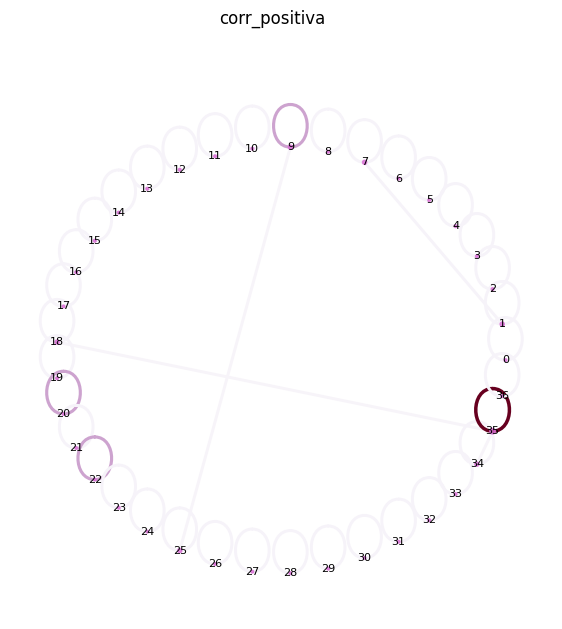

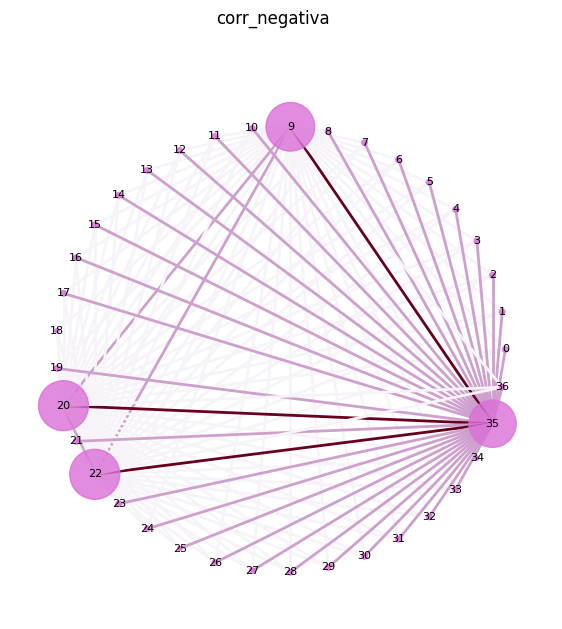

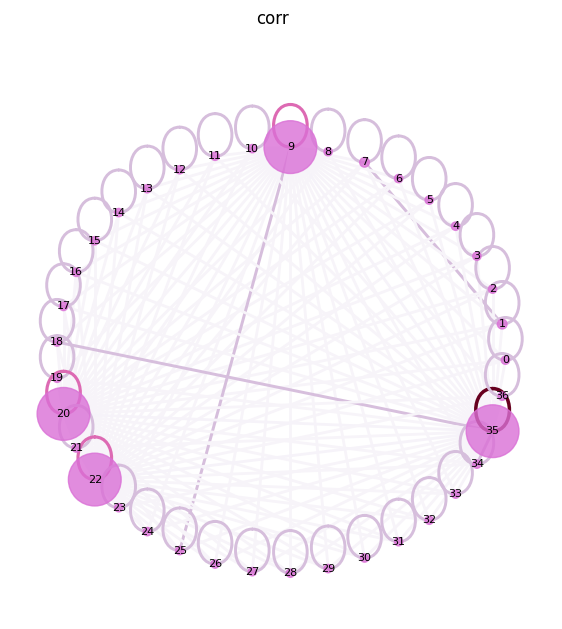

In [8]:
create_corr_network(Graphos[350],0.0001,"corr_positiva")
create_corr_network(Graphos[350],0.0001,"corr_negativa")
create_corr_network(Graphos[350],0.0001)

In [9]:
def CNM(G,alpha,show=0):
    nx.write_graphml(G,'temp.graphml')
    Gi = ig.read('temp.graphml',format="graphml")
    dendrogram_cnm = Gi.community_fastgreedy(weights="weight")
    optimal_count_cnm = dendrogram_cnm.optimal_count
    print("CNM Optimum community count for",alpha/100,"is", optimal_count_cnm)

    if show:
    # convert it into a flat clustering
        clusters_cnm = dendrogram_cnm.as_clustering()
        return ig.plot(clusters_cnm, label=True, mark_groups = True, target='clusters.png')
    else:
        return optimal_count_cnm

In [10]:
optimal_count_cnm=[CNM(GraphosD[alpha],alpha) for alpha in alphas]

CNM Optimum community count for 3.5 is 33
CNM Optimum community count for 3.8 is 65
CNM Optimum community count for 4.0 is 14
CNM Optimum community count for 4.2 is 13
CNM Optimum community count for 4.5 is 12


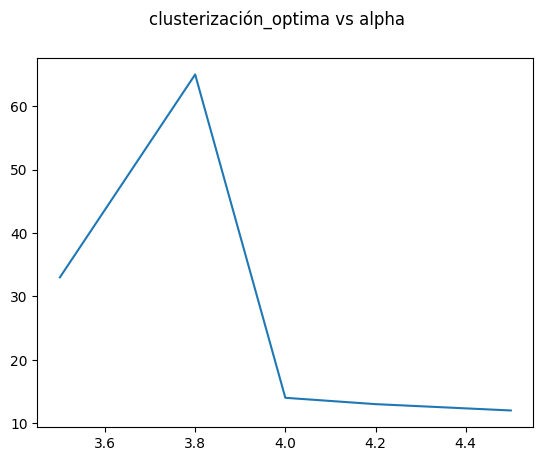

In [50]:
plt.suptitle("clusterización_optima vs alpha")
plt.plot([alpha/100 for alpha in alphas],optimal_count_cnm)
plt.savefig("clusterización_optima vs alpha", format="PNG")

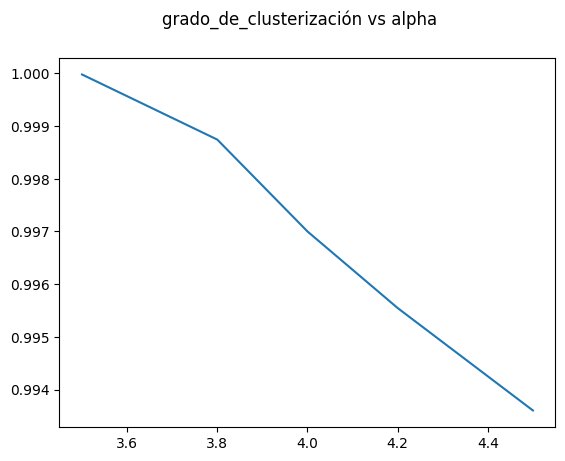

In [11]:
plt.suptitle("grado_de_clusterización vs alpha")
plt.plot([alpha/100 for alpha in alphas],[(optimal_count_cnm[i]+alphas[i]*500-np.shape(correlacionClausula[alphas[i]])[0])/(alphas[i]*500) for i in range(len(alphas))])
plt.savefig("clusterización_optima vs alpha", format="PNG")

CNM Optimum community count for 3.5 is 33


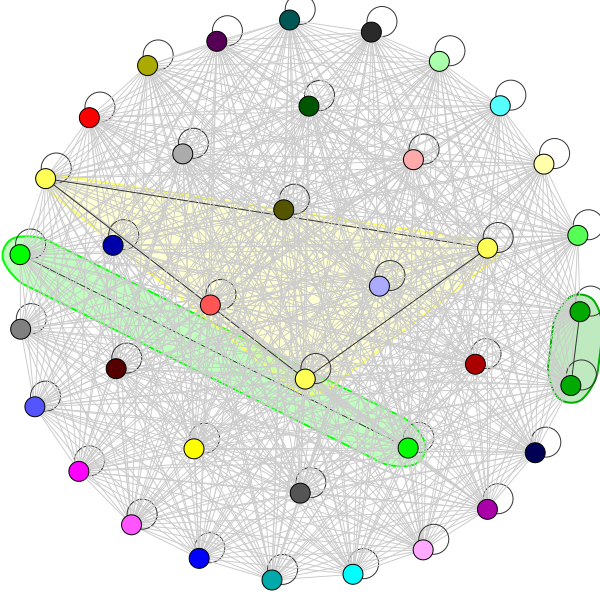

In [47]:
CNM(GraphosD[350],350,1)